In [1]:
""" Compare simulated and observed water table and water table depth,
return different criteria and plot results """

## Import Python modules
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xlrd
from datetime import datetime

plt.rcParams['figure.figsize'] = [16.5, 9.0]


## Import paths
path_model_outputs = 'C:/CWATM_output/'
path_observed_data = 'C:/FUSE/fromLuca/Measured_data/WaterTable/'
Inputs_file_modflow = 'C:/GitHub/FUSE/Modflow/modflow_inputs/2_ModFlow_inputs500m_Bhima/'

## Loading files containing basin grid information
Size = np.loadtxt(Inputs_file_modflow + 'UB_limits.txt')
basin = np.loadtxt(Inputs_file_modflow + 'Basin_limits.txt')
res_ModFlow = (Size[1]-Size[0])/(Size[5]-1)  # in [m]
print('ModFlow resolution is : ', res_ModFlow, ' meters')
# Map dimensions
ncol = int((Size[1]-Size[0])/res_ModFlow)+1 
nrow = int(abs((Size[3]-Size[2])/res_ModFlow)+1)
basin = basin.reshape(nrow,ncol)              # ModFlow format


ModFlow resolution is :  500.0  meters


In [2]:
## Upload simulated water
ds = xr.open_dataset(path_model_outputs + 'modflowWaterLevel_monthend.nc')
GWTable_ModFlow = ds['modflowWaterLevel_monthend'][:].data              # Matrix of water levels [m] (time, nrow, ncol)
Time_ModFlow = ds['time'][:].data
Time_ModFlowV2 = (Time_ModFlow - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
Time_ModFlowV3 = np.zeros(len(Time_ModFlow))
for it in range(len(Time_ModFlow)):
    dd = datetime.utcfromtimestamp(Time_ModFlowV2[it])
    Time_ModFlowV3[it] = dd.toordinal()
ds.close()

## Upload topography defined in ModFlow and soil thickness defined in CWATM
ds = xr.open_dataset(path_model_outputs + 'modflowtotalSoilThickness_totalend.nc')
Soil_thickness = ds['modflowtotalSoilThickness_totalend'][:].data 
ds.close()
Top = np.loadtxt(Inputs_file_modflow + 'Topo.txt')

Topography_ModFlow = Top.reshape(nrow,ncol) + Soil_thickness # We need to add soil thickness to compare WTD


c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """


c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
c:\users\mikha\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]),
 <a list of 10 Text yticklabel objects>)

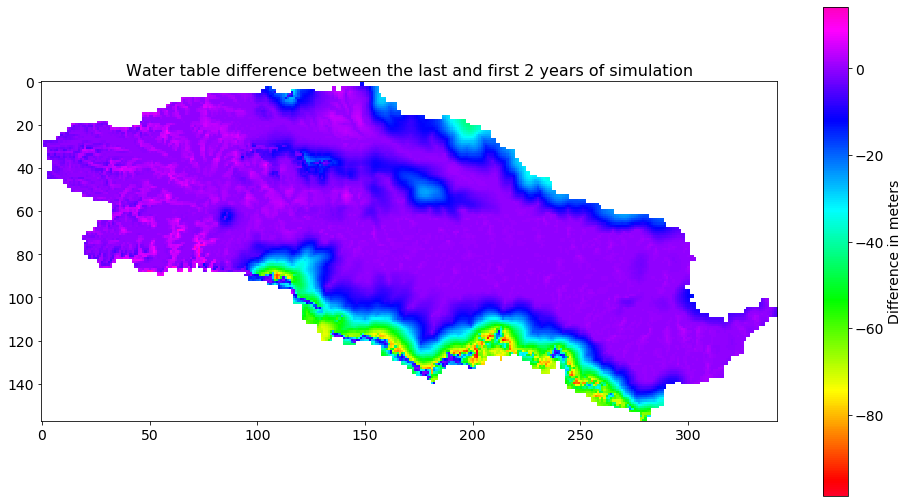

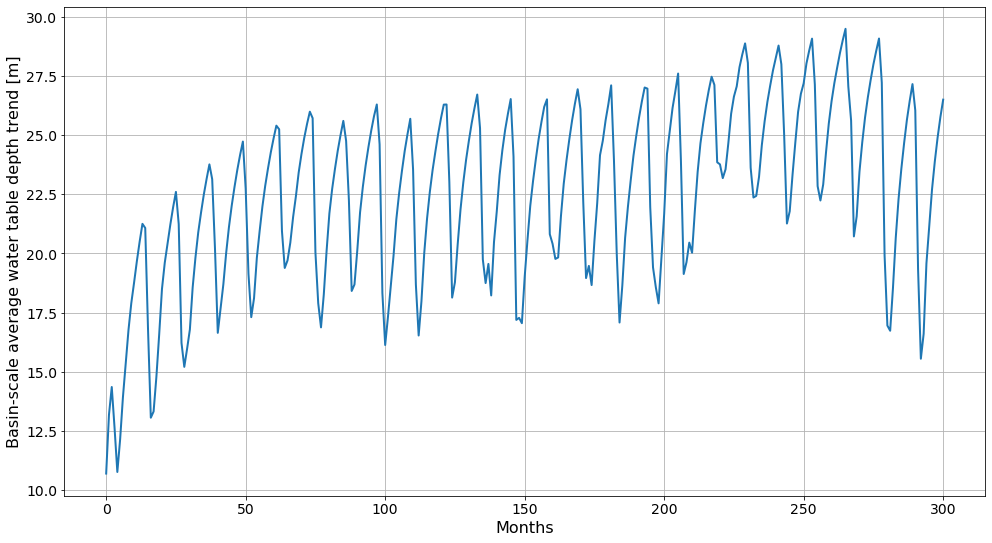

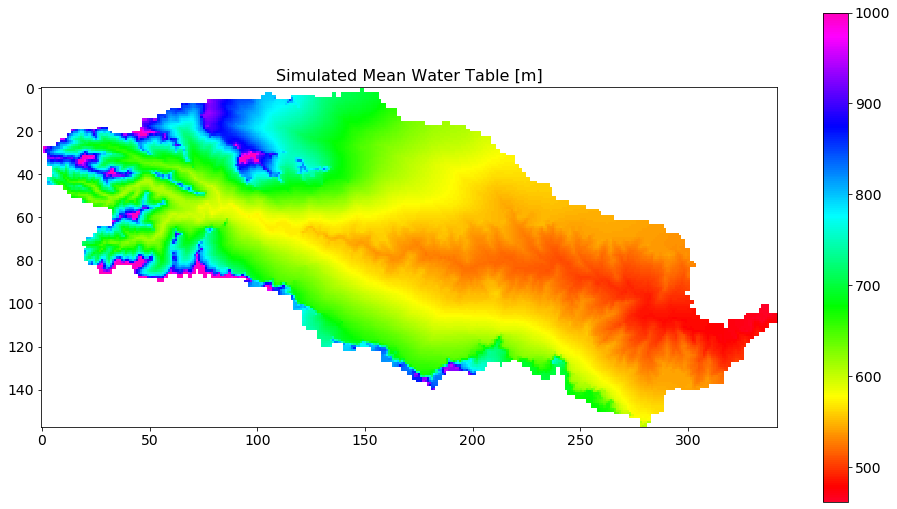

c:\users\mikha\envs\test\lib\site-packages\matplotlib\colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


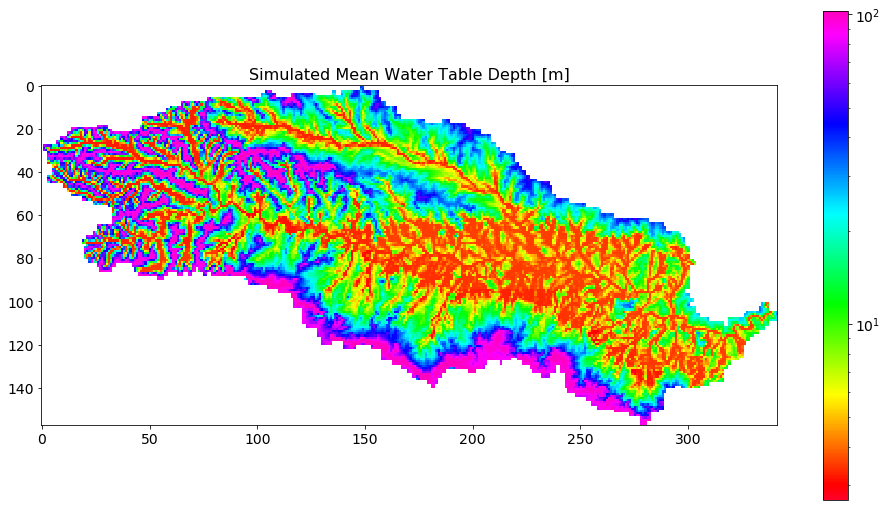

In [3]:
## Plot the water balance trend in Groundwater:
cmap = plt.cm.gist_rainbow
plt.figure()
# as we record water table at the end of each month 2*12 is equal to 2 yrs
plt.imshow((np.mean(GWTable_ModFlow[-2*12:],0)-np.mean(GWTable_ModFlow[0:2*12],0)), cmap=cmap)
plt.title('Water table difference between the last and first 2 years of simulation', fontsize=16)
cb = plt.colorbar()
cb.set_label('Difference in meters', fontsize=14)
cb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.figure()
plt.plot(np.nanmean(np.nanmean(Topography_ModFlow - GWTable_ModFlow,1),1), linewidth=2)
plt.ylabel('Basin-scale average water table depth trend [m]', fontsize=16)
plt.xlabel('Months', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()

## Computing the mean map of simulated water table and water table depth
MeanWaterTable = np.nanmean(GWTable_ModFlow,0)
MeanWaterTableDepth = Topography_ModFlow - MeanWaterTable

plt.figure()
plt.imshow(MeanWaterTable, cmap=cmap, vmax=1000)
plt.title('Simulated Mean Water Table [m]', fontsize=16)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.figure()
plt.imshow(MeanWaterTableDepth, norm=LogNorm(vmin=np.nanmin(MeanWaterTableDepth), vmax=np.nanmax(MeanWaterTableDepth)), cmap=cmap)
plt.title('Simulated Mean Water Table Depth [m]', fontsize=16)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


Number of boreholes in the Bhima basin :  382
Number of boreholes used for water table comparison in the selected basin :  51


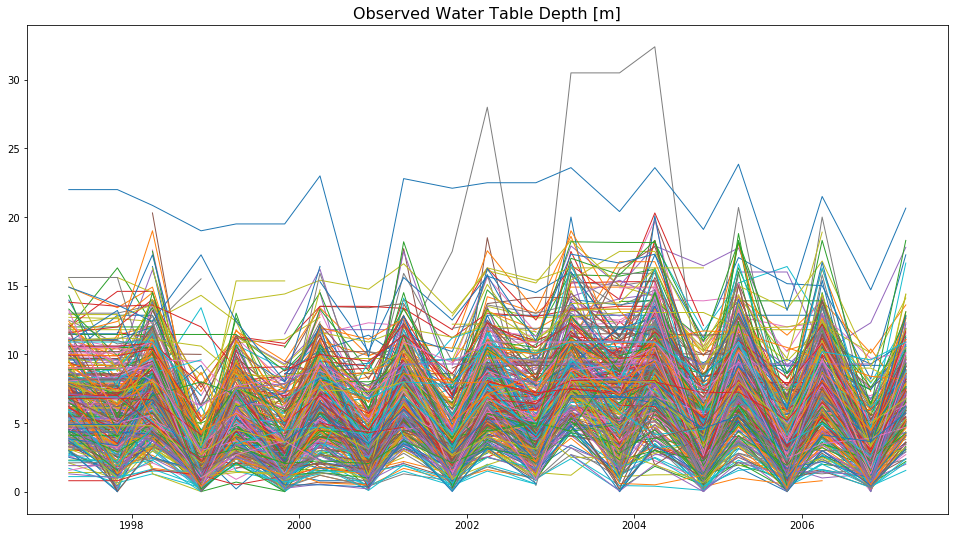

In [4]:
## UPLOAD OBSERVED WATER TABLE AND FIND THE MODFLOW COORDINATES OF EACH BOREHOLE

## Upload observed water table depth
Measured_watertabledepth = np.zeros((382,21)) # 2D array containing measured data: 382 boreholes for Bhima, 21 dates
wb = xlrd.open_workbook(path_observed_data + "UB_GW_DataProcessed.xls")
sh = wb.sheet_by_name(u'Sheet1')
for il in range(np.shape(Measured_watertabledepth)[0]):
    for ic in range(np.shape(Measured_watertabledepth)[1]):
        val=sh.row_values(il+1)[ic]
        if val == '':
            Measured_watertabledepth[il][ic] = np.nan
        else:
            Measured_watertabledepth[il][ic] = val

## Upload associated dates
Measured_dates = np.zeros(np.shape(Measured_watertabledepth)[1])
for ic in range(np.shape(Measured_watertabledepth)[1]):
    # dd = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[0]) - 2).strftime('%Y%m%d')
    Measured_dates[ic] = datetime(1900, 1, 1).toordinal() + int(sh.row_values(0)[ic]) - 2

## Plot observed water table depth
plt.figure()
for il in range(np.shape(Measured_watertabledepth)[0]):
    plt.plot_date(Measured_dates, Measured_watertabledepth[il], linestyle='solid', marker=None, linewidth=1)
plt.title('Observed Water Table Depth [m]', fontsize=16)
    
## Upload coordinates, water table and topography of each borehole
x_GW = np.loadtxt(path_observed_data + 'GW_level_x.txt')
y_GW = np.loadtxt(path_observed_data + 'GW_level_y.txt')
z_GW = np.loadtxt(path_observed_data + 'GW_level_z.txt')

## List containing only boreholes in the basin and not too close from the basin limit (at least 1 cell)
x_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])   # Boreholes out of the basin will be removed after            
y_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0]) 
z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])
wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                 # Observed water table
wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))                # Observed water table depth
Sim_wtd_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))            # Simulated water table
Sim_wt_GW_bhima = np.zeros((np.shape(Measured_watertabledepth)[0],np.shape(Measured_watertabledepth)[1]))             # Simulated water table depth
Sim_z_GW_bhima = np.zeros(np.shape(Measured_watertabledepth)[0])              # Altitude of the cell in the model (differnt from borehole information)

## Preparing data for the linear interpolation inside the grid
X = np.arange(0, ncol)
Y = np.arange(0, nrow)
X,Y = np.meshgrid(X,Y)
points = np.array( (X.flatten(), Y.flatten()) ).T

# We assume the period April 1997 to April 2007 is included in the model
# For each date of observation, we look for the closer date of simulation
Index_measured_date = np.zeros(len(Measured_dates))
for it in range(len(Measured_dates)):
    Index_measured_date[it] = np.argmin(np.abs(Time_ModFlowV3-Measured_dates[it])) # index corresponding to the closer date

valuesWaterTable = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))
valuesWaterTableDepth = np.zeros((np.shape(Measured_watertabledepth)[1], nrow*ncol))

for it in range(len(Measured_dates)): # For each measured time
    PiezoMap = GWTable_ModFlow[int(Index_measured_date[it])]
    PiezoDepthMap = Topography_ModFlow - GWTable_ModFlow[int(Index_measured_date[it])]
    valuesWaterTable[it] = PiezoMap.flatten()           # Map of the simulated water table for each date of observation
    valuesWaterTableDepth[it] = PiezoDepthMap.flatten() # Map of the simulated water table depth for each date of observation

valuesTopography_ModFlow = Topography_ModFlow.flatten() # Map of the topography defined in ModFlow

som=0
for pz in range(len(x_GW)): # For each monitoring borehole

    # Find the corresponding column and row where the borehole is located
    colPz = int(round((x_GW[pz]-float(Size[0]))/res_ModFlow))
    rowPz = int(round((float(Size[2])-y_GW[pz])/res_ModFlow))

    if colPz>0 and rowPz>0 and colPz<ncol and rowPz<nrow:       # If the borehole is in the model
        if basin[rowPz][colPz] == 1:         # If the borehole is in the basin

            # If the cell is not too close from an inactive cell (= too close from the basin limits)
            if basin[rowPz-1][colPz]*basin[rowPz+1][colPz]*basin[rowPz][colPz-1]*basin[rowPz][colPz+1] !=0:
                som=som+1

                x_GW_bhima[som-1] = x_GW[pz]
                y_GW_bhima[som-1] = y_GW[pz]
                z_GW_bhima[som-1] = z_GW[pz]
                wtd_GW_bhima[som-1][:] = Measured_watertabledepth[pz]               # Each column corresponds to a specific date between April 1997 and April 2007
                wt_GW_bhima[som-1][:] = z_GW[pz]-Measured_watertabledepth[pz]

                # Interpolating the simulated value as observation points are not in the cells center
                X0 = (x_GW[pz]-float(Size[0]))/res_ModFlow
                Y0 = (float(Size[2])-y_GW[pz])/res_ModFlow

                # As interpolation seems to long for the Bhima, we create a new grid closer from the observation point
                points2 = points[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                
                # Interpolation
                valuesTopography_ModFlow2 = valuesTopography_ModFlow[np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                Val = griddata(points2, valuesTopography_ModFlow2, (X0,Y0), method='linear' )
                Sim_z_GW_bhima[som-1] = Val

                compt=0
                for ii in range(len(Measured_dates)): # For each measured time

                    valuesWaterTableDepth2 = valuesWaterTableDepth[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    valuesWaterTable2 = valuesWaterTable[ii][np.sqrt((points[:,0]-X0)**2+(points[:,1]-Y0)**2) < 2]
                    Val = griddata(points2, valuesWaterTableDepth2, (X0,Y0), method='linear' )
                    Sim_wtd_GW_bhima[som-1][compt] = Val
                    Val = griddata(points2, valuesWaterTable2, (X0,Y0), method='linear' )
                    Sim_wt_GW_bhima[som-1][compt] = Val
                    compt+=1

print('Number of boreholes in the Bhima basin : ', np.shape(Measured_watertabledepth)[0])            
print('Number of boreholes used for water table comparison in the selected basin : ', som)

## Keep only boreholes inside the basin and not too close from the basin limits
x_GW_bhima = x_GW_bhima[:som]       
y_GW_bhima = y_GW_bhima[:som] 
z_GW_bhima = z_GW_bhima[:som] 
wt_GW_bhima = wt_GW_bhima[:som] 
wtd_GW_bhima = wtd_GW_bhima[:som] 
Sim_wtd_GW_bhima = Sim_wtd_GW_bhima[:som] 
Sim_wt_GW_bhima = Sim_wt_GW_bhima[:som] 
Sim_z_GW_bhima = Sim_z_GW_bhima[:som]


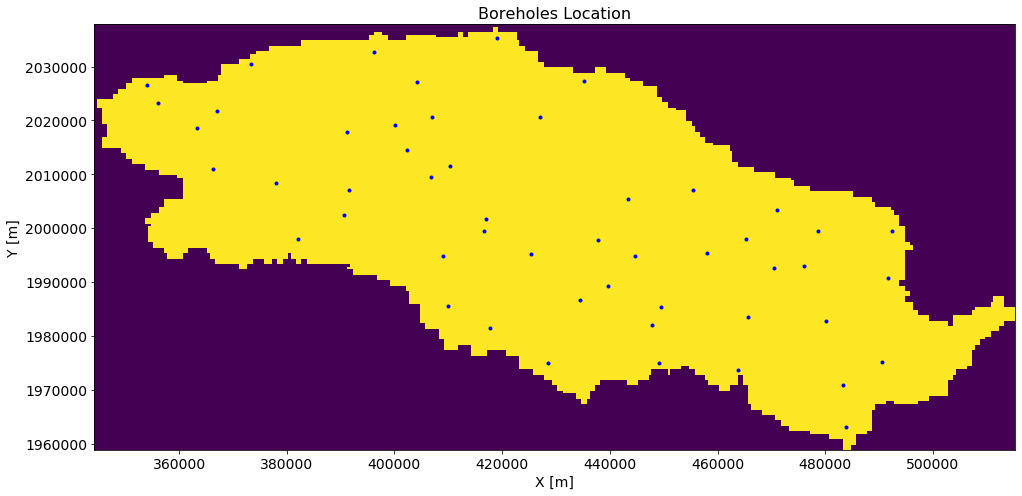

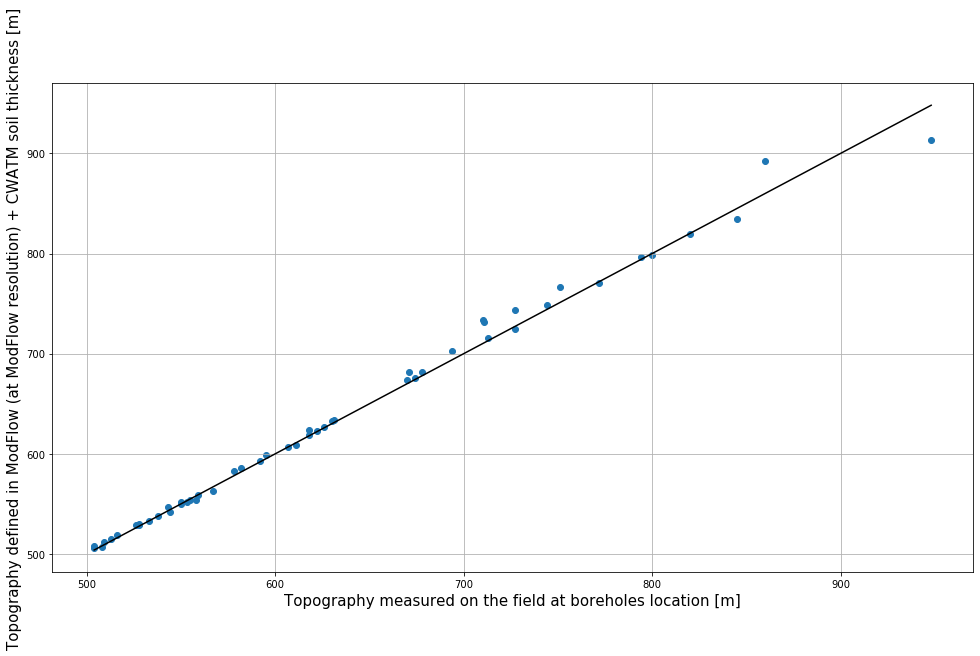

In [5]:
## CHECK IF THE EXTRACTION SEEMS OK

## Plot the map of the basin and associated boreholes position
plt.figure()
plt.subplot(1, 1, 1, aspect='equal')
plt.title('Boreholes Location', fontsize=16)
extent = (float(Size[0])-res_ModFlow/2, float(Size[1])+res_ModFlow/2, float(Size[2])+res_ModFlow/2, float(Size[3])-res_ModFlow/2)
cmap = plt.cm.Greys
cmap.set_under(color='white')
cmap.set_over(color='black')
plt.imshow(basin, extent=extent, interpolation='none', origin='lower')
plt.gca().invert_yaxis()
for k in range(len(x_GW_bhima)):
    plt.plot(x_GW_bhima[k], y_GW_bhima[k], color='b', marker='o', markersize=3, markerfacecoloralt='b')

plt.ylabel('Y [m]', fontsize=14)
plt.xlabel('X [m]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Plot the simulated and observed topography: TAKE CARE ABOUT THE ACTUAL TOPOGRAPHY IN CWATM (botm[0]+soilthickness)
plt.figure()
plt.scatter(z_GW_bhima, Sim_z_GW_bhima, marker='o')
plt.plot([np.min(z_GW_bhima),np.max(z_GW_bhima)], [np.min(z_GW_bhima),np.max(z_GW_bhima)], color='k')
plt.ylabel('Topography defined in ModFlow (at ModFlow resolution) + CWATM soil thickness [m]', fontsize=15)
plt.xlabel('Topography measured on the field at boreholes location [m]', fontsize=15)
plt.grid()


(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text yticklabel objects>)

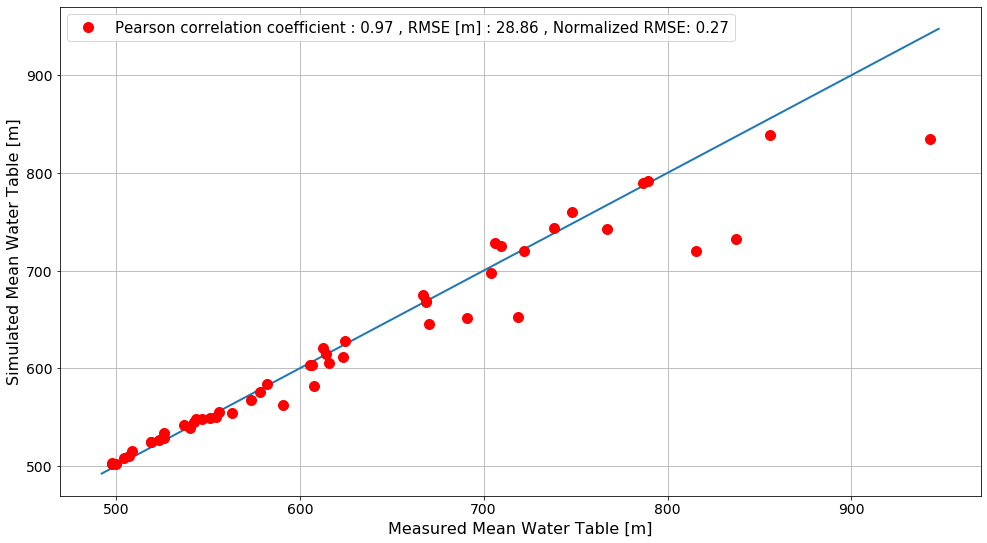

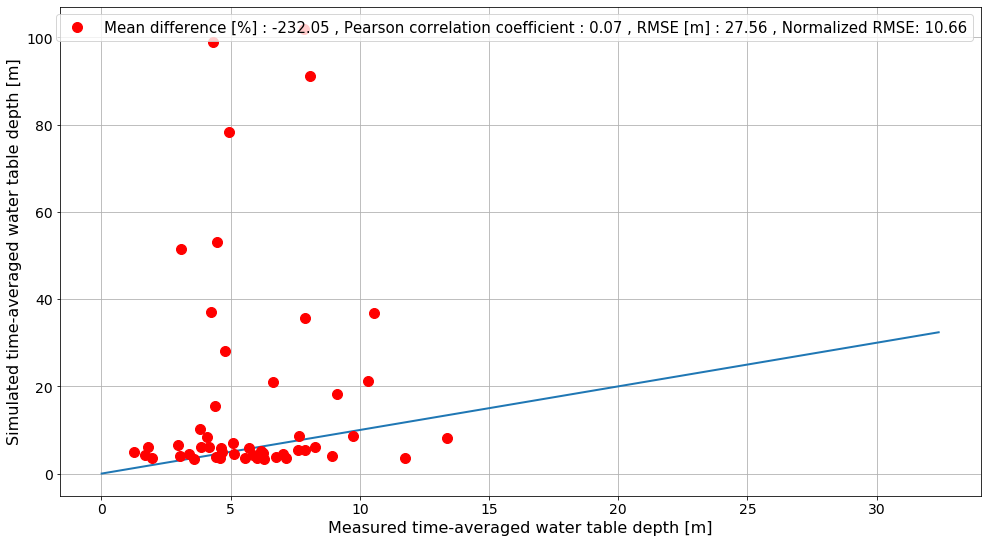

In [6]:
## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
## MEAN VALUE ## -> compute a global RMS error, normalized difference, normalized RMSE and coefficient of correlation

## Time averaging of simulate and observed data
Mean_Sim_wt_GW_bhima = np.mean(Sim_wt_GW_bhima,1)
Mean_Sim_wtd_GW_bhima = np.mean(Sim_wtd_GW_bhima,1)
Mean_wt_GW_bhima = np.nanmean(wt_GW_bhima,1)    # nanmean is used because there are nan values in observed data
Mean_wtd_GW_bhima = np.nanmean(wtd_GW_bhima,1)

## Correlation COEFFICIENT
PearsonWaterTable = np.corrcoef(Mean_wt_GW_bhima, Mean_Sim_wt_GW_bhima)    
CorrWaterTable = PearsonWaterTable[0][1]
PearsonWaterTableDepth = np.corrcoef(Mean_wtd_GW_bhima, Mean_Sim_wtd_GW_bhima)    
CorrWaterTableDepth = PearsonWaterTableDepth[0][1]

## MEAN Normalize water table depth difference
average_Norm_diffDepth = np.mean((Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100) # In percentage
Norm_diffDepth = (Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)/Mean_wtd_GW_bhima*100 # In percentage

## MEAN Root mean square error
RmseWaterTable = np.sqrt(np.sum((Mean_wt_GW_bhima - Mean_Sim_wt_GW_bhima)**2) / len(Mean_wt_GW_bhima))
RmseWaterTableDepth = np.sqrt(np.sum((Mean_wtd_GW_bhima - Mean_Sim_wtd_GW_bhima)**2) / len(Mean_wtd_GW_bhima))

## MEAN normalized Root mean square error
RmseWaterTable_norm = RmseWaterTable/np.std(Mean_wt_GW_bhima)
RmseWaterTableDepth_norm = RmseWaterTableDepth/np.std(Mean_wtd_GW_bhima)


## Plot time-averaged results for water table comparison
plt.figure()
# Print the perfect line 1/1
plt.plot([np.nanmin(wt_GW_bhima),np.nanmax(wt_GW_bhima)],[np.nanmin(wt_GW_bhima),np.nanmax(wt_GW_bhima)], linestyle='solid', linewidth=2, marker=None)
label1 = 'Pearson correlation coefficient : ' + str(round(CorrWaterTable*100)/100) + ' , RMSE [m] : ' + str(round(RmseWaterTable*100)/100) + ' , Normalized RMSE: ' + str(round(RmseWaterTable_norm*100)/100) 
plt.plot(Mean_wt_GW_bhima, Mean_Sim_wt_GW_bhima, marker='o', markersize=10, color='r', linestyle='', label=label1)
plt.xlabel('Measured Mean Water Table [m]', fontsize=16)
plt.ylabel('Simulated Mean Water Table [m]', fontsize= 16)
plt.grid()
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Plot time-averaged results for water table depth comparison
plt.figure()
# Print the perfect line 1/1
plt.plot([np.nanmin(wtd_GW_bhima),np.nanmax(wtd_GW_bhima)],[np.nanmin(wtd_GW_bhima),np.nanmax(wtd_GW_bhima)], linestyle='solid', linewidth=2, marker=None)
label2 = 'Mean difference [%] : ' + str(round(average_Norm_diffDepth*100)/100) + ' , Pearson correlation coefficient : ' + str(round(CorrWaterTableDepth*100)/100) + ' , RMSE [m] : ' + str(round(RmseWaterTableDepth*100)/100) + ' , Normalized RMSE: ' + str(round(RmseWaterTableDepth_norm*100)/100) 
plt.plot(Mean_wtd_GW_bhima, Mean_Sim_wtd_GW_bhima, marker='o', markersize=10, color='r', linestyle='', label=label2)
plt.xlabel('Measured time-averaged water table depth [m]', fontsize= 16)
plt.ylabel('Simulated time-averaged water table depth [m]', fontsize= 16)
plt.grid()
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


Text(0.5, 1.0, 'Normalized root mean square error on water table fluctuations (average across all boreholes) : 1.09')

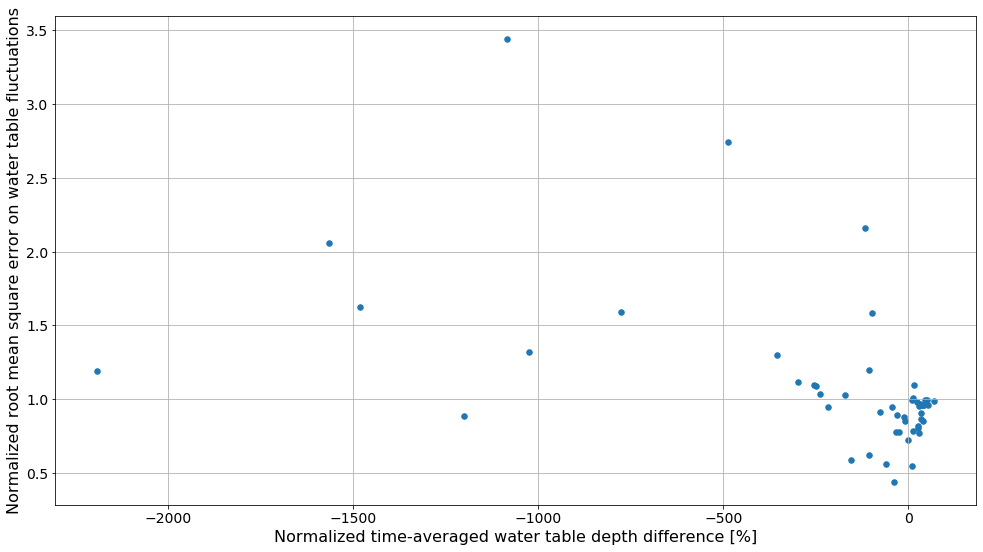

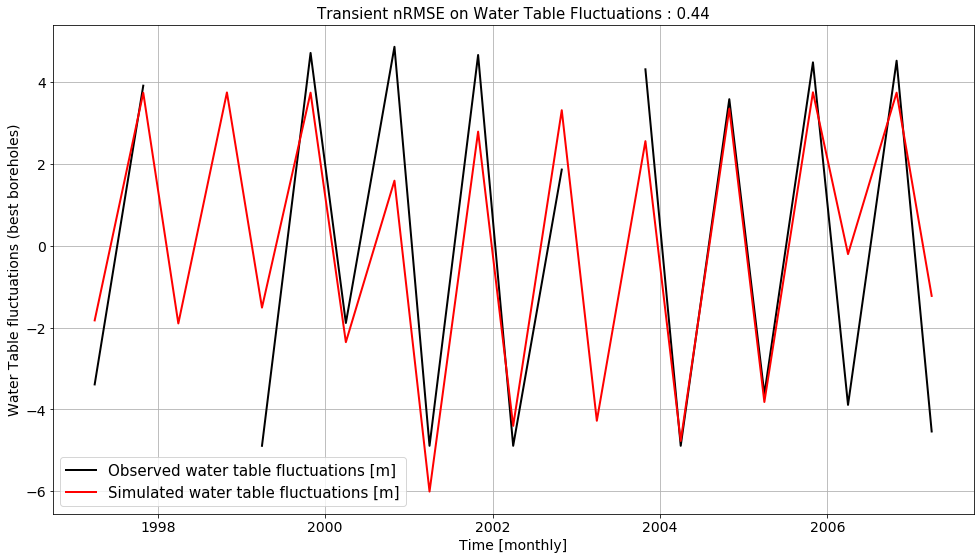

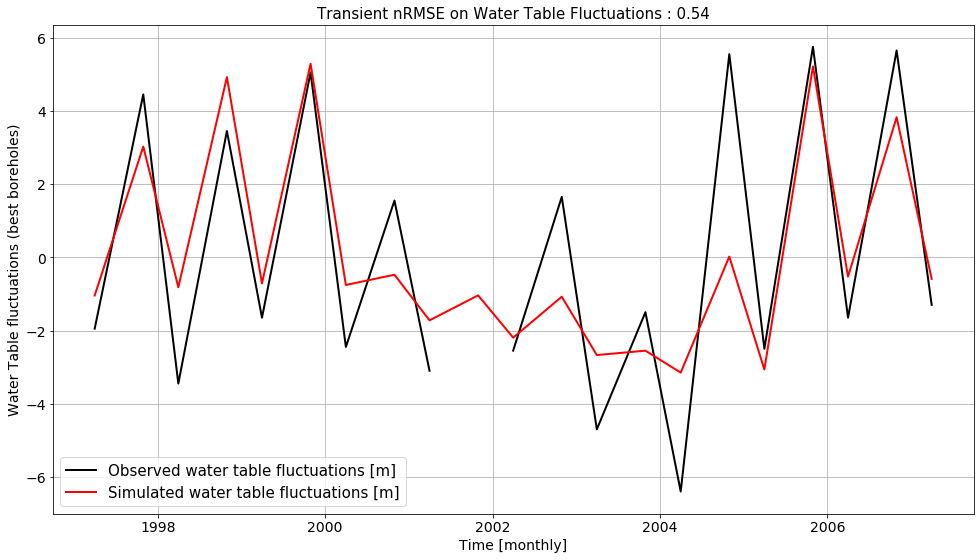

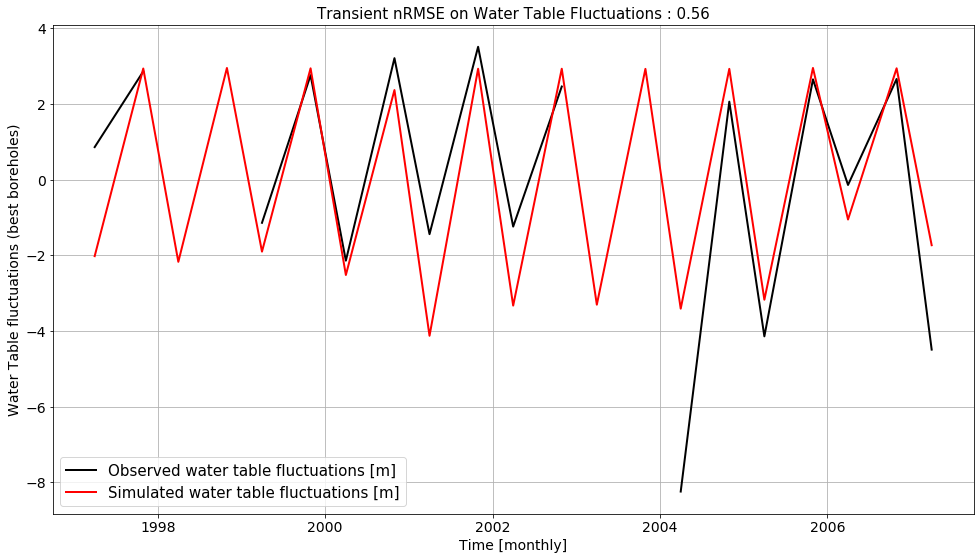

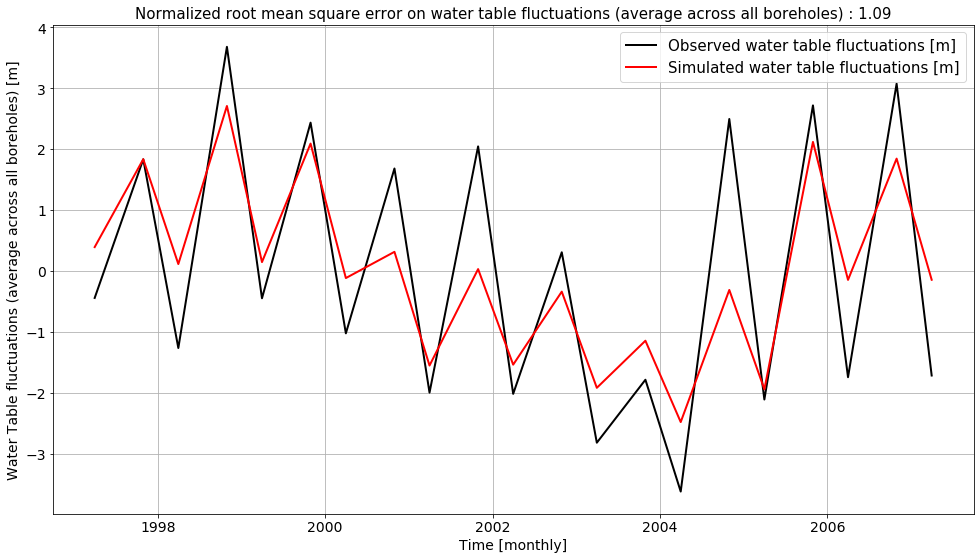

In [7]:
## COMPUTING ROOT MEAN SQUARE ERROR AND CORELATION BETWEEN OBSERVATION AND SIMULATION ##
## TRANSIENT VALUE ## -> compute nRMSE for each borehole, after subtracting the mean as the mean behavior is already compared by other criteria

## Computing normalized root mean square error on water table fluctuations for each borehole
Transient_nRMSE = np.zeros(len(wt_GW_bhima))
for ib in range(len(wt_GW_bhima)): # For each borehole
    Transient_nRMSE[ib] = np.sqrt(np.nansum((wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])-(Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])))**2) / np.count_nonzero(~np.isnan(wt_GW_bhima[ib]))) / np.nanstd(wt_GW_bhima[ib])

# Mean value of the nRMSE in transient
Average_transient_nRMSE = np.nanmean(Transient_nRMSE)    

## Plot the Transient_nRMSE in function of normalized difference between water table depth
plt.figure()
plt.scatter(Norm_diffDepth, Transient_nRMSE, marker='o', s=30)
plt.xlabel('Normalized time-averaged water table depth difference [%]', fontsize= 16)
plt.ylabel('Normalized root mean square error on water table fluctuations', fontsize= 16)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Plot the best 3 boreholes for water table fluctuations
sorted_Transient_nRMSE = np.argsort(Transient_nRMSE)
for i in range(3):
    plt.figure()
    plt.plot_date(Measured_dates, wt_GW_bhima[sorted_Transient_nRMSE[i]]-np.nanmean(wt_GW_bhima[sorted_Transient_nRMSE[i]]), label='Observed water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='k')
    plt.plot_date(Measured_dates, Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]]-np.nanmean(Sim_wt_GW_bhima[sorted_Transient_nRMSE[i]]), label='Simulated water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='r')
    plt.grid()
    plt.legend(fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time [monthly]', fontsize=14)
    plt.ylabel('Water Table fluctuations (best boreholes)', fontsize=14)
    txt_title = 'Transient nRMSE on Water Table Fluctuations : ' + str(np.round(Transient_nRMSE[sorted_Transient_nRMSE[i]]*100)/100)
    plt.title(txt_title, fontsize=15)

## Plot the mean storage fluctuations at boreholes,
plt.figure()
wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
Sim_wt_fluctu = np.zeros((len(wt_GW_bhima),len(Measured_dates)))
for ib in range(len(wt_GW_bhima)):
    wt_fluctu[ib] = wt_GW_bhima[ib]-np.nanmean(wt_GW_bhima[ib])
    Sim_wt_fluctu[ib] = Sim_wt_GW_bhima[ib]-np.nanmean(Sim_wt_GW_bhima[ib])
plt.plot_date(Measured_dates, np.nanmean(wt_fluctu, 0), label='Observed water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='k')
plt.plot_date(Measured_dates, np.nanmean(Sim_wt_fluctu, 0), label='Simulated water table fluctuations [m]', linestyle='solid', marker=None, linewidth=2, color='r')
plt.grid()
plt.legend(fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time [monthly]', fontsize=14)
plt.ylabel('Water Table fluctuations (average across all boreholes) [m]', fontsize=14)
txt_title = 'Normalized root mean square error on water table fluctuations (average across all boreholes) : ' + str(np.round(Average_transient_nRMSE*100)/100)
plt.title(txt_title, fontsize=15)
